# Install and import libraries

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statistics

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import transformers
from transformers import BertForTokenClassification, AdamW
from transformers import get_linear_schedule_with_warmup

from seqeval.metrics import f1_score, accuracy_score

2023-07-07 17:04:11.439111: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-07 17:04:11.982896: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Check GPU availability

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2080 Ti'

# **Preprocessing data**

In [3]:
# Reading data
import json


#open the file, and format correctly
f =open('dataset.jsonl', 'r')
json_object = json.dumps(f.readlines(), indent=4)
f.close()

#save better format into file
p = open('sample.txt', 'w')
for i in json_object:
    p.write(i)
p.close()

#open new file, and save each 
j = open('sample.txt', 'r')
text = json.loads(j.read())
j.close()

#compile all json dicts into a list
info = []
for i in text:
    info.append(json.loads(str(i)))
    

In [4]:
def labeler1(sent, text, annotations):
    #sent will be the already parsed sentence, with everything removed
    #text will be the straight sentence, info[i]['text']
    #annotations will be the list of labels, must be info[i]['annotations']
    
    #monitor where in the text we are
    text_index = 0
    
    #monitor which word we are in
    sent_index = 0
    
    #keep track of which annotation label we are applying
    annotation_index = 0
    
    #will return all labels for each words
    labels = []
  
    while text_index < len(text) and sent_index < len(sent):
        if annotation_index >= len(annotations):
            for i in range(len(labels)-1, len(sent)):
                labels.append(data_tags[0])
                return labels
        
        #check if we are at the correct index
        if text[text_index]== sent[sent_index][0]:
            
            #double check
            if len(sent[sent_index])==1 or text[text_index+1]== sent[sent_index][1]:
                
                #if not true and the current label aplies to text behind the index behind current, adjest label that you are looking at
                if text_index > annotations[annotation_index]['end_offset']:
                    annotation_index +=1
                    
                else:
            
                    #check if the current text label falls in a label range.
                    #if true, apply correct label and move text_index and sent_index
                    if text_index >= annotations[annotation_index]['start_offset'] and text_index <= annotations[annotation_index]['end_offset']:
                        if len(labels)==0:
                            labels.append(data_tags[2*(annotations[annotation_index]['label'])])
                        elif labels[-1] == data_tags[2*(annotations[annotation_index]['label'])] or labels[-1] == data_tags[2*(annotations[annotation_index]['label'])-1]:
                            labels.append(data_tags[2*(annotations[annotation_index]['label'])])
                        else:
                            labels.append(data_tags[2*(annotations[annotation_index]['label'])-1])
                    
                    #if no label applies, apply '0' tag
                    else:
                        labels.append(data_tags[0])
                    
                    #adjust which word you are looking at and text_index
                    text_index += len(sent[sent_index])
                    sent_index += 1
                    
                
            else:
                text_index+=1
        else:
            text_index+=1
            
            
    return labels
        
 

In [5]:
def labeler1(sent, text, annotations):
    #sent will be the already parsed sentence, with everything removed
    #text will be the straight sentence, info[i]['text']
    #annotations will be the list of labels, must be info[i]['annotations']
    
    #monitor where in the text we are
    text_index = 0
    
    #monitor which word we are in
    sent_index = 0
    
    #keep track of which annotation label we are applying
    annotation_index = 0
    
    #will return all labels for each words
    labels = []
  
    while text_index < len(text) and sent_index < len(sent):
        if annotation_index >= len(annotations):
            for i in range(len(labels)-1, len(sent)):
                labels.append(data_tags[0])
                return labels
        
        #check if we are at the correct index
        if text[text_index]== sent[sent_index][0]:
            
            #double check
            if len(sent[sent_index])==1 or text[text_index+1]== sent[sent_index][1]:
                
                #if not true and the current label aplies to text behind the index behind current, adjest label that you are looking at
                if text_index > annotations[annotation_index]['end_offset']:
                    annotation_index +=1
                    
                else:
            
                    #check if the current text label falls in a label range.
                    #if true, apply correct label and move text_index and sent_index
                    if text_index >= annotations[annotation_index]['start_offset'] and text_index <= annotations[annotation_index]['end_offset']:
                        if len(labels)==0:
                            labels.append(data_tags[2*(annotations[annotation_index]['label'])])
                        elif labels[-1] == data_tags[2*(annotations[annotation_index]['label'])] or labels[-1] == data_tags[2*(annotations[annotation_index]['label'])]:
                            labels.append(data_tags[2*(annotations[annotation_index]['label'])])
                        else:
                            labels.append(data_tags[2*(annotations[annotation_index]['label'])])
                    
                    #if no label applies, apply '0' tag
                    else:
                        labels.append(data_tags[0])
                    
                    #adjust which word you are looking at and text_index
                    text_index += len(sent[sent_index])
                    sent_index += 1
                    
                
            else:
                text_index+=1
        else:
            text_index+=1
            
            
    return labels
        
 

In [6]:
def labeler2(sent, text, annotations):
    #sent will be the already parsed sentence, with everything removed
    #text will be the straight sentence, info[i]['text']
    #annotations will be the list of labels, must be info[i]['annotations']
    
    #monitor where in the text we are
    text_index = 0
    
    #keep track of which annotation label we are applying
    annotation_index = 0
    
    #will return all labels for each words
    labels = []
    
    for i in range(0, len(sent)):
        if len(annotations) ==0:
            return [data_tags[0] for j in range(len(sent[i]))]
                    
        elif text_index == annotations[annotation_index]['start_offset']:
            
            labels.append(data_tags[2 * annotations[annotation_index]['label']-1])
            
        elif text_index >= annotations[annotation_index]['start_offset'] and text_index <= annotations[annotation_index]['end_offset']:
            if labels[i-1]==data_tags[0]:
                
                labels.append(data_tags[2 * annotations[annotation_index]['label']-1])
            else:
               
                labels.append(data_tags[(2 * annotations[annotation_index]['label'] ) ])
            
        elif text_index > annotations[annotation_index]['end_offset']:
            if text_index + 1 == annotations[annotation_index]['start_offset']:
                
                labels.append(data_tags[2 * annotations[annotation_index]['label']-1])
            else: 
                annotation_index+=1
               
                labels.append(data_tags[0])
                if annotation_index>=len(annotations):
                    annotation_index = annotation_index -1
        else:
        
            labels.append(data_tags[0])
            
        text_index+= (len(sent[i])+1)
    return labels
    

In [7]:
def all_in_one (text, annotations):
    #text will be the straight sentence, info[i]['text']
    #annotations will be the list of labels, must be info[i]['annotations']
    
    partitions = []
    section_labels = []
    labels = []
    sentences = []
    
    a_len =  len(annotations)
    t_len = len(text)
    
    if a_len == 0:
        sentences = text.split()
        for s in sentences:
            labels.append(data_tags[0])
        return sentences, labels
    
    if annotations[0]['start_offset'] == 0:
        partitions.append(text[: annotations[0]['end_offset']])
        section_labels.append(annotations[0]['label'])
    else:
        partitions.append(text[: annotations[0]['start_offset']])
        section_labels.append(0)
        partitions.append(text[annotations[0]['start_offset']: annotations[0]['end_offset']])
        section_labels.append(annotations[0]['label'])
        
        
    for i in range(1, a_len -1):
        if annotations[i]['start_offset'] == annotations[i-1]['end_offset']:
            partitions.append(text[annotations[i]['start_offset']: annotations[i]['end_offset']])
            section_labels.append(annotations[i]['label'])
        else:
            partitions.append(text[annotations[i-1]['end_offset']: annotations[i]['start_offset']])
            section_labels.append(0)
            partitions.append(text[annotations[i]['start_offset']: annotations[i]['end_offset']])
            section_labels.append(annotations[i]['label'])
            
    
    if annotations[a_len-1]['start_offset'] == t_len:
        partitions.append(text[annotations[a_len-1]['start_offset']:])
        section_labels.append(annotations[a_len-1]['label'])
    else:
        partitions.append(text[annotations[a_len-1]['start_offset']: annotations[a_len-1]['end_offset']])
        section_labels.append(annotations[a_len-1]['label'])
        partitions.append(text[annotations[a_len-1]['end_offset']: ])
        section_labels.append(0)
        
        
    for i in range(len(section_labels)):
        p_split = partitions[i].split()
        p_len = len(p_split)
        if p_len > 0:
            sentences.extend(p_split)
            if section_labels[i] == 0:
                for p in p_split:
                    labels.append(data_tags[0])
            else:
                labels.append(data_tags[2 * section_labels[i] -1])
                for j in range(1, p_len):
                     labels.append(data_tags[2 * section_labels[i]])
      
    return sentences, labels
    

In [8]:
import re

def splitter1():
    return [re.findall(r"[\w']+", info[i]['text']) for i in range(len(info))]

def splitter2():
    return [info[i]['text'].strip().split() for i in range(len(info))]
   

In [9]:
def processor(splitmethod, labelmethod):
    s = splitmethod()
    
    l=[]

    for i in range(len(s)):
        l.append(labelmethod(s[i], info[i]['text'].strip(), info[i]['annotations'] ))
    
    return s, l

In [10]:
#create labels
data_tags = ['0','C', 'C-cont' , 'M', 'M-cont', 'Q', 'Q-cont', 'T' , 'T-cont', 'A' , 'A-cont', 'R', 'R-cont']

# sentences, labels = processor(splitter1, labeler1)

# sentences, labels = [], []
# for i in range(len(info)):
#     sent, label = all_in_one(info[i]['text'], info[i]['annotations'])
#     sentences.append(sent)
#     labels.append(label)
    
sentences, labels = processor(splitter2, labeler2) 
  

In [11]:
for i in range(len(labels[124])):
    print(sentences[124][i],labels[124][i])

The 0
results 0
on 0
Fig. 0
2b 0
show 0
that 0
hydrochloric A
acid A-cont
desorbates 0
obtained 0
after 0
the 0
90Sr/90Y 0
pair 0
sorption 0
by 0
the 0
D5041 0
cation 0
exchange 0
resin 0
from 0
0.2–0.3 Q
M Q-cont
HNO3 0
solutions A
and 0
washing 0
with 0
HCl A
solutions 0
of 0
the 0
same 0
concentrations 0
contain 0
almost 0
pure 0
90Y. M
The 0
residual 0
activity 0
of 0
desorbates 0
after 0
keeping 0
for 0
45 T
days T-cont
does 0
not 0
exceed 0
0.1% Q
of 0
the 0
initial 0
activity 0
of 0
the 0
solution, 0
and 0
the 0
experimental 0
and 0
calculated 0
decomposition 0
curves 0
of 0
desorbates 0
almost 0
completely 0
coincide. 0


In [12]:

# Determine the list of tags
tag_values = data_tags
print(tag_values)

tag_values.append("PAD")
print(tag_values)

tag2idx = {t: i for i, t in enumerate(tag_values)}
print(tag2idx)
     

['0', 'C', 'C-cont', 'M', 'M-cont', 'Q', 'Q-cont', 'T', 'T-cont', 'A', 'A-cont', 'R', 'R-cont']
['0', 'C', 'C-cont', 'M', 'M-cont', 'Q', 'Q-cont', 'T', 'T-cont', 'A', 'A-cont', 'R', 'R-cont', 'PAD']
{'0': 0, 'C': 1, 'C-cont': 2, 'M': 3, 'M-cont': 4, 'Q': 5, 'Q-cont': 6, 'T': 7, 'T-cont': 8, 'A': 9, 'A-cont': 10, 'R': 11, 'R-cont': 12, 'PAD': 13}


In [13]:
# To use the BERT, you must use the BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('allenai/scibert_scivocab_cased', do_lower_case=True)


In [14]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


In [15]:
tokenized_texts_and_labels = [ tokenize_and_preserve_labels(sent, labs) for sent, labs in zip(sentences, labels)]

tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [16]:
# MAX_LEN is the maximum length of a sequence
MAX_LEN = 64 # 64 or 128 or ...
bs = 20 # batch size


In [17]:
# Use Padding to equalize the length of sentences
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")
     

In [18]:
# Do not mask values that are zero
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [19]:
# Split data to train and validation. %90 for train and %10 for validation
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)

# Each mask contains 10% of a sentence
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

# The input of the BERT should be the tensors produced using PyTorch
# So convert all inputs and labels into torch tensors
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)

tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)

tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

# Create the DataLoader for our training set
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

print(train_sampler)

# Create the DataLoader for our validation set
valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


# **Build model**

In [20]:
# Load BERT Model

model = BertForTokenClassification.from_pretrained(
    "allenai/scibert_scivocab_cased",
    num_labels=len(tag2idx), # The number of output labels
    output_attentions = False, # Whether the model returns attention weights.
    output_hidden_states = False # Whether the model returns all hidden-states.
)

Some weights of the model checkpoint at allenai/scibert_scivocab_cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initial

In [21]:
# Tell PyTorch to run this model on the GPU
model.cuda();

In [22]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr= 1e-5, # learning-rate default is 3e-5
    eps=1e-8 # adam-epsilon default is 1e-8
)


/home/ecasey/anaconda3/envs/torch/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [23]:
epochs = 50

max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=30,
    num_training_steps=total_steps
)

# **Training**

In [24]:
def acc(print_labels):
    accuracy_list = []
    
    for i in range(len(sentences)):

        tokenized_sentence = tokenizer.encode(sentences[i])
        input_ids = torch.tensor([tokenized_sentence]).cuda()

        with torch.no_grad():
            output = model(input_ids)

        label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

        # join bpe split tokens
        tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
        new_tokens, new_labels = [], []
        for token, label_idx in zip(tokens, label_indices[0]):
            if token.startswith("##"):
                new_tokens[-1] = new_tokens[-1] + token[2:]
            else:
                new_labels.append(tag_values[label_idx])
                new_tokens.append(token)

        new_labels = new_labels[1:-2]
        accuracy_list.append(accuracy_score(new_labels, labels[i]))
        if print_labels == True:
            print("\nPredict labels: ",new_labels)
            print("Actual labels: ",labels[i])

    return statistics.mean(accuracy_list)



In [25]:
## Store the average loss after each epoch so we can plot them.
import copy
loss_values, validation_loss_values = [], []

test_acc = []

max_test = 10

for e in trange(epochs, desc="Epoch"):
    
    
    
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("\nAverage train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("\nValidation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]

    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    #print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()
    a = eval_loss
    test_acc.append(a)
    if a <= max_test:
        max_test = a
    elif a * 1.2 == max_test:    
        torch.save(model, "test.ck")
    

Epoch:   2%|█▊                                                                                        | 1/50 [00:01<00:56,  1.16s/it]


Average train loss: 2.521981567144394

Validation loss: 2.4274439811706543
Validation Accuracy: 0.2625



Epoch:   4%|███▌                                                                                      | 2/50 [00:01<00:40,  1.17it/s]


Average train loss: 2.19359228014946

Validation loss: 1.941414713859558
Validation Accuracy: 0.7488636363636364



Epoch:   6%|█████▍                                                                                    | 3/50 [00:02<00:35,  1.34it/s]


Average train loss: 1.554717943072319

Validation loss: 1.475464940071106
Validation Accuracy: 0.7738636363636363



Epoch:   8%|███████▏                                                                                  | 4/50 [00:03<00:32,  1.43it/s]


Average train loss: 1.2203414663672447

Validation loss: 1.3751392364501953
Validation Accuracy: 0.7738636363636363



Epoch:  10%|█████████                                                                                 | 5/50 [00:03<00:30,  1.49it/s]


Average train loss: 1.0407133847475052

Validation loss: 1.1786717176437378
Validation Accuracy: 0.7818181818181819



Epoch:  12%|██████████▊                                                                               | 6/50 [00:04<00:28,  1.53it/s]


Average train loss: 0.9282714799046516

Validation loss: 1.0589547157287598
Validation Accuracy: 0.8136363636363636



Epoch:  14%|████████████▌                                                                             | 7/50 [00:04<00:27,  1.55it/s]


Average train loss: 0.8479153290390968

Validation loss: 0.9312113523483276
Validation Accuracy: 0.8238636363636364



Epoch:  16%|██████████████▍                                                                           | 8/50 [00:05<00:26,  1.56it/s]


Average train loss: 0.7107054516673088

Validation loss: 0.7809870839118958
Validation Accuracy: 0.8318181818181818



Epoch:  18%|████████████████▏                                                                         | 9/50 [00:06<00:26,  1.58it/s]


Average train loss: 0.6900352016091347

Validation loss: 0.6605479717254639
Validation Accuracy: 0.8386363636363636



Epoch:  20%|█████████████████▊                                                                       | 10/50 [00:06<00:25,  1.58it/s]


Average train loss: 0.5835984945297241

Validation loss: 0.5488554239273071
Validation Accuracy: 0.8420454545454545



Epoch:  22%|███████████████████▌                                                                     | 11/50 [00:07<00:24,  1.59it/s]


Average train loss: 0.5388175621628761

Validation loss: 0.4735619127750397
Validation Accuracy: 0.8534090909090909



Epoch:  24%|█████████████████████▎                                                                   | 12/50 [00:08<00:23,  1.59it/s]


Average train loss: 0.47017886117100716

Validation loss: 0.42776167392730713
Validation Accuracy: 0.8636363636363636



Epoch:  26%|███████████████████████▏                                                                 | 13/50 [00:08<00:23,  1.59it/s]


Average train loss: 0.39151506498456

Validation loss: 0.4022129476070404
Validation Accuracy: 0.8590909090909091



Epoch:  28%|████████████████████████▉                                                                | 14/50 [00:09<00:22,  1.59it/s]


Average train loss: 0.39090605452656746

Validation loss: 0.3634205460548401
Validation Accuracy: 0.8897727272727273



Epoch:  30%|██████████████████████████▋                                                              | 15/50 [00:09<00:21,  1.59it/s]


Average train loss: 0.33934760093688965

Validation loss: 0.3471989631652832
Validation Accuracy: 0.8818181818181818



Epoch:  32%|████████████████████████████▍                                                            | 16/50 [00:10<00:21,  1.59it/s]


Average train loss: 0.33383317291736603

Validation loss: 0.32513102889060974
Validation Accuracy: 0.8943181818181818



Epoch:  34%|██████████████████████████████▎                                                          | 17/50 [00:11<00:20,  1.59it/s]


Average train loss: 0.29409024119377136

Validation loss: 0.3204508423805237
Validation Accuracy: 0.8920454545454546



Epoch:  36%|████████████████████████████████                                                         | 18/50 [00:11<00:20,  1.59it/s]


Average train loss: 0.2930784095078707

Validation loss: 0.30297183990478516
Validation Accuracy: 0.8965909090909091



Epoch:  38%|█████████████████████████████████▊                                                       | 19/50 [00:12<00:19,  1.59it/s]


Average train loss: 0.24766014702618122

Validation loss: 0.29478999972343445
Validation Accuracy: 0.9011363636363636



Epoch:  40%|███████████████████████████████████▌                                                     | 20/50 [00:13<00:18,  1.59it/s]


Average train loss: 0.2443883940577507

Validation loss: 0.293056845664978
Validation Accuracy: 0.8931818181818182



Epoch:  42%|█████████████████████████████████████▍                                                   | 21/50 [00:13<00:18,  1.59it/s]


Average train loss: 0.23206362314522266

Validation loss: 0.2910006642341614
Validation Accuracy: 0.8943181818181818



Epoch:  44%|███████████████████████████████████████▏                                                 | 22/50 [00:14<00:17,  1.59it/s]


Average train loss: 0.19319522939622402

Validation loss: 0.2873165011405945
Validation Accuracy: 0.9045454545454545



Epoch:  46%|████████████████████████████████████████▉                                                | 23/50 [00:14<00:16,  1.60it/s]


Average train loss: 0.1769961677491665

Validation loss: 0.28383034467697144
Validation Accuracy: 0.9011363636363636



Epoch:  48%|██████████████████████████████████████████▋                                              | 24/50 [00:15<00:16,  1.60it/s]


Average train loss: 0.1868403535336256

Validation loss: 0.2853280305862427
Validation Accuracy: 0.9022727272727272



Epoch:  50%|████████████████████████████████████████████▌                                            | 25/50 [00:16<00:15,  1.59it/s]


Average train loss: 0.16764577850699425

Validation loss: 0.28159189224243164
Validation Accuracy: 0.9034090909090909



Epoch:  52%|██████████████████████████████████████████████▎                                          | 26/50 [00:16<00:15,  1.59it/s]


Average train loss: 0.16115160938352346

Validation loss: 0.2853940725326538
Validation Accuracy: 0.9034090909090909



Epoch:  54%|████████████████████████████████████████████████                                         | 27/50 [00:17<00:14,  1.59it/s]


Average train loss: 0.15335257537662983

Validation loss: 0.2879457175731659
Validation Accuracy: 0.9022727272727272



Epoch:  56%|█████████████████████████████████████████████████▊                                       | 28/50 [00:18<00:13,  1.59it/s]


Average train loss: 0.1345800617709756

Validation loss: 0.293649822473526
Validation Accuracy: 0.9011363636363636



Epoch:  58%|███████████████████████████████████████████████████▌                                     | 29/50 [00:18<00:13,  1.59it/s]


Average train loss: 0.12627444881945848

Validation loss: 0.299811452627182
Validation Accuracy: 0.8988636363636363



Epoch:  60%|█████████████████████████████████████████████████████▍                                   | 30/50 [00:19<00:12,  1.59it/s]


Average train loss: 0.13227206747978926

Validation loss: 0.3033407926559448
Validation Accuracy: 0.9011363636363636



Epoch:  62%|███████████████████████████████████████████████████████▏                                 | 31/50 [00:19<00:11,  1.59it/s]


Average train loss: 0.11374594271183014

Validation loss: 0.31173697113990784
Validation Accuracy: 0.8977272727272727



Epoch:  64%|████████████████████████████████████████████████████████▉                                | 32/50 [00:20<00:11,  1.58it/s]


Average train loss: 0.11604215390980244

Validation loss: 0.30287787318229675
Validation Accuracy: 0.9034090909090909



Epoch:  66%|██████████████████████████████████████████████████████████▋                              | 33/50 [00:21<00:10,  1.58it/s]


Average train loss: 0.12629084754735231

Validation loss: 0.3006858825683594
Validation Accuracy: 0.9045454545454545



Epoch:  68%|████████████████████████████████████████████████████████████▌                            | 34/50 [00:21<00:10,  1.58it/s]


Average train loss: 0.10932456515729427

Validation loss: 0.30130258202552795
Validation Accuracy: 0.9022727272727272



Epoch:  70%|██████████████████████████████████████████████████████████████▎                          | 35/50 [00:22<00:09,  1.59it/s]


Average train loss: 0.1051354305818677

Validation loss: 0.30346816778182983
Validation Accuracy: 0.9011363636363636



Epoch:  72%|████████████████████████████████████████████████████████████████                         | 36/50 [00:23<00:08,  1.59it/s]


Average train loss: 0.09404360456392169

Validation loss: 0.3116842806339264
Validation Accuracy: 0.8977272727272727



Epoch:  74%|█████████████████████████████████████████████████████████████████▊                       | 37/50 [00:23<00:08,  1.59it/s]


Average train loss: 0.09802821092307568

Validation loss: 0.3066576421260834
Validation Accuracy: 0.9045454545454545



Epoch:  76%|███████████████████████████████████████████████████████████████████▋                     | 38/50 [00:24<00:07,  1.59it/s]


Average train loss: 0.09161112317815423

Validation loss: 0.30633652210235596
Validation Accuracy: 0.9034090909090909



Epoch:  78%|█████████████████████████████████████████████████████████████████████▍                   | 39/50 [00:25<00:06,  1.59it/s]


Average train loss: 0.09539432357996702

Validation loss: 0.3077552318572998
Validation Accuracy: 0.9022727272727272



Epoch:  80%|███████████████████████████████████████████████████████████████████████▏                 | 40/50 [00:25<00:06,  1.59it/s]


Average train loss: 0.08974512293934822

Validation loss: 0.3078934848308563
Validation Accuracy: 0.9056818181818181



Epoch:  82%|████████████████████████████████████████████████████████████████████████▉                | 41/50 [00:26<00:05,  1.59it/s]


Average train loss: 0.08381244353950024

Validation loss: 0.3089504837989807
Validation Accuracy: 0.9034090909090909



Epoch:  84%|██████████████████████████████████████████████████████████████████████████▊              | 42/50 [00:26<00:05,  1.59it/s]


Average train loss: 0.10702539421617985

Validation loss: 0.30906686186790466
Validation Accuracy: 0.9079545454545455



Epoch:  86%|████████████████████████████████████████████████████████████████████████████▌            | 43/50 [00:27<00:04,  1.59it/s]


Average train loss: 0.07915603322908282

Validation loss: 0.31043699383735657
Validation Accuracy: 0.9045454545454545



Epoch:  88%|██████████████████████████████████████████████████████████████████████████████▎          | 44/50 [00:28<00:03,  1.59it/s]


Average train loss: 0.07721552136354148

Validation loss: 0.3123483657836914
Validation Accuracy: 0.9056818181818181



Epoch:  90%|████████████████████████████████████████████████████████████████████████████████         | 45/50 [00:28<00:03,  1.59it/s]


Average train loss: 0.07460350822657347

Validation loss: 0.3144311308860779
Validation Accuracy: 0.9045454545454545



Epoch:  92%|█████████████████████████████████████████████████████████████████████████████████▉       | 46/50 [00:29<00:02,  1.59it/s]


Average train loss: 0.09613196179270744

Validation loss: 0.3154260814189911
Validation Accuracy: 0.9034090909090909



Epoch:  94%|███████████████████████████████████████████████████████████████████████████████████▋     | 47/50 [00:30<00:01,  1.59it/s]


Average train loss: 0.09481273544952273

Validation loss: 0.31586089730262756
Validation Accuracy: 0.9045454545454545



Epoch:  96%|█████████████████████████████████████████████████████████████████████████████████████▍   | 48/50 [00:30<00:01,  1.59it/s]


Average train loss: 0.0776626905426383

Validation loss: 0.31609806418418884
Validation Accuracy: 0.9079545454545455



Epoch:  98%|███████████████████████████████████████████████████████████████████████████████████████▏ | 49/50 [00:31<00:00,  1.59it/s]


Average train loss: 0.0749002848751843

Validation loss: 0.3165389597415924
Validation Accuracy: 0.9079545454545455



Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.56it/s]


Average train loss: 0.08192129665985703

Validation loss: 0.3165714740753174
Validation Accuracy: 0.9068181818181819



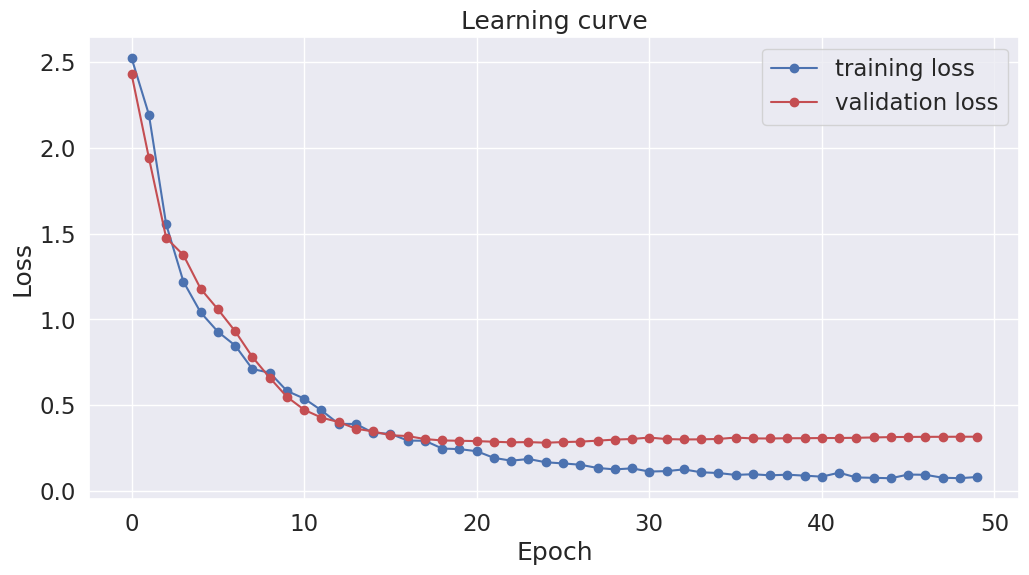

In [26]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

# Performance on test data

In [27]:
print(test_acc)

[2.4274439811706543, 1.941414713859558, 1.475464940071106, 1.3751392364501953, 1.1786717176437378, 1.0589547157287598, 0.9312113523483276, 0.7809870839118958, 0.6605479717254639, 0.5488554239273071, 0.4735619127750397, 0.42776167392730713, 0.4022129476070404, 0.3634205460548401, 0.3471989631652832, 0.32513102889060974, 0.3204508423805237, 0.30297183990478516, 0.29478999972343445, 0.293056845664978, 0.2910006642341614, 0.2873165011405945, 0.28383034467697144, 0.2853280305862427, 0.28159189224243164, 0.2853940725326538, 0.2879457175731659, 0.293649822473526, 0.299811452627182, 0.3033407926559448, 0.31173697113990784, 0.30287787318229675, 0.3006858825683594, 0.30130258202552795, 0.30346816778182983, 0.3116842806339264, 0.3066576421260834, 0.30633652210235596, 0.3077552318572998, 0.3078934848308563, 0.3089504837989807, 0.30906686186790466, 0.31043699383735657, 0.3123483657836914, 0.3144311308860779, 0.3154260814189911, 0.31586089730262756, 0.31609806418418884, 0.3165389597415924, 0.3165714

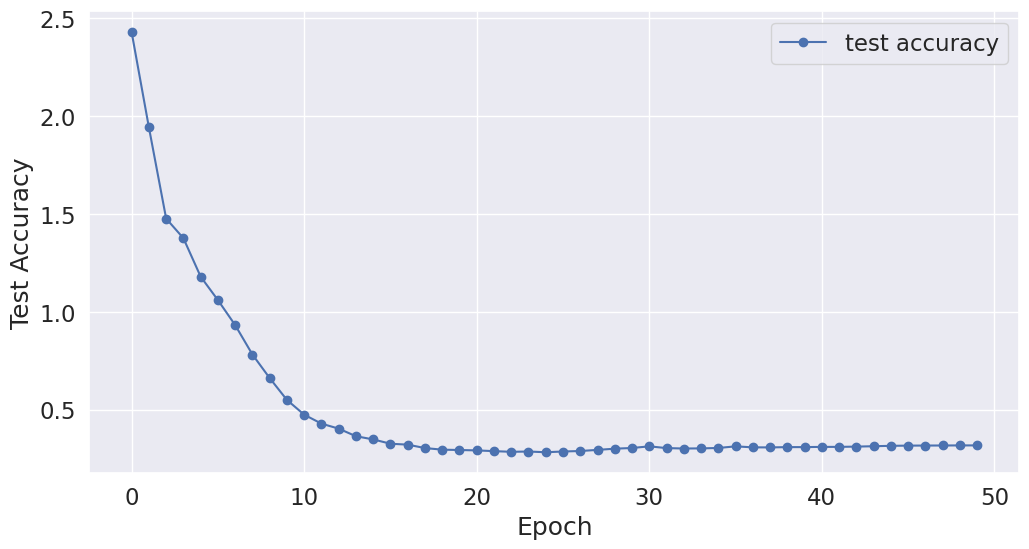

In [28]:
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(test_acc, 'b-o', label="test accuracy")


# Label the plot.
plt.title("")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.legend()

plt.show()

In [29]:
sentences, labels = processor(splitter1, labeler1)
print(acc(False))
acc(True)


0.6974062743708762

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'R', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q-cont', 'Q-cont', '0', '0', '0', '0', 'Q', 'Q', 'Q-cont', 'Q-cont', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'R-cont', 'R-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 


Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'T', 'T-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'T', 'T-cont', '0', 'T', 'T-cont', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'T-cont', 'T-cont', 'Q-cont', '0', '0', '0', 'Q-cont', 'Q-cont', '0', '0', '0', 'T-cont', 'T-cont', '0', 'T-cont', 'T-cont', '0']

Predict labels:  ['0', '0', '0', '0', '0', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', '0', 'Q', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', 'Q', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'M']
Actual labels:  ['0', 'M-cont', '0', '0', '0', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', '0', 'Q-cont', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', 'Q-cont', 'Q-


Predict labels:  ['0', '0', '0', 'Q', 'Q', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont']
Actual labels:  ['0', '0', '0', 'Q-cont', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q-cont', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', 'Q-cont', 'Q-cont', 'Q-cont']

Predict labels:  ['0', '0', '0', '0', '0', 'M', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', '0', '0', '0', '0', '0', 'M', '0', 'M', 'M', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', '0', 'M', '0', 'M', '0', '0', '0', '0']
Actual labels:  ['0', '0'


Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', '0', '0', '0', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', '0', '0', 'C', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'T', 'T-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'T', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q-cont', 'Q-cont', '0', '0', '0', '0', '0', '0', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q-cont', 'Q-cont', '0', '0', 'C-cont', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'T-cont', 'T-cont', 'T-cont', 'T-cont']

Predict labels:  ['0', '0', '0', '0', '0', '0', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 


Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'R-cont', 'R-cont', 'R-cont', 'R-cont', '0', '0', '0', 'M-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', '0', '0', 'M-cont', 'M-cont', '0', '0', '0', '0', '0', '0', 'R-cont', 'R-cont', '0', '0', '0', 'Q-cont', 'Q-cont', 'Q-cont', '0',

0.6974062743708762

In [30]:
sentences, labels = processor(splitter2, labeler2)
print(acc(False))
acc(True)

0.8657525794257097

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', 'Q', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', 'Q', '0', '0', '0', '0', '0', 'Q', 'Q', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'R', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', '0', '0', 'M', '0', '0', '0', '0', '0', '0', 'R', '0', '0', 


Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'T', 'T-cont', 'T-cont', '0', '0', '0', '0', '0', '0', '0', 'T', 'T-cont', '0', 'T', 'T-cont', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'T', 'T-cont', '0', '0', '0', '0', '0', '0', '0', '0', 'T', 'T-cont', '0', 'T', 'T-cont', '0', '0', '0', '0', '0']

Predict labels:  ['0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q', '0', '0', 'Q', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', 'Q', 'Q-cont', '0', '0']
Actual labels:  ['0', 'M', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', '0', '0', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', '0', 'Q', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0']

Predict labels:  ['0', '0', '0', '0', 'PAD', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q


Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont']
Actual labels:  ['0', '0', '0', '0', 'Q', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', '0']

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', 'M', '0', '0', '0', '0', 'M', 'Q', 'M', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', '0', '0', '0', 'M', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0'


Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', '0', '0', 'C', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'T', 'T-cont', 'T']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', '0', '0', '0', '0', '0', '0', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', '0', '0', 'C', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'T', 'T-cont', 'T-cont', 'T-cont']

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'PAD', 'M', 'M', '0', '0', '0', 'C', '0', '0', '0', '0', '0', '0', '0', '0', 'T', 'T-cont'


Predict labels:  ['0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', 'M', '0', '0', '0', '0', 'M', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', '0', '0', '0', '0', '0', 'T']
Actual labels:  ['0', '0', '0', '0', 'C', '0', '0', 'C', 'C-cont', '0', '0', 'M', '0', '0', '0', '0', '0', 'M', '0', 'C', '0', '0', '0', '0', 'Q', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', '0', '0', '0', '0', '0', 'T', 'T-cont']

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',

0.8657525794257097

In [31]:
sentences, labels = [], []
for i in range(len(info)):
    sent, label = all_in_one(info[i]['text'], info[i]['annotations'])
    sentences.append(sent)
    labels.append(label)
print(acc(False))
acc(True)

0.8325000733116918

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', '0', 'Q', 'Q', 'Q', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0


Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', '0', '0', 'M', 'M', 'M', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', '0', '0', '0', '0', 'Q', 'Q', 'T-cont', '0', '0', 'T', 'T-cont', 'T-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', 'M', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', '0', '0', '0', '0', 'C', 'C-cont', '0', '0', '0', 'T', 'T-cont', '0', 'Q', '0', '0', '0', '0', 'Q', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', 'Q', 'C', 'C', 'C-cont', 'C-cont', 'C', 'C-cont', 'C-cont', '0', '0', '0', '0', '0', '0']

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'T', 'T-cont', 'T-cont', 'T-cont', 'T-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'T', 'T-cont', 'T-cont', 


Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q', '0', '0', '0', 'A', 'A-cont', 'A-cont', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'A', '0', '0', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', '0', '0', 'A', 'A-cont', 'M', '0', '0', '0', '0', '0', '0', '0']

Predict labels:  ['0', '0', '0', '0', 'Q', 'Q', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont']
Actual labels:  ['0', '0', '0', '0', 'Q'


Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', 'C', 'C-cont', '0']

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', '0', '0', 'C', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', 'T-cont']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', '0', '0', '0', '0', '0', '0', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', '0', '0', 'C', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'T', 'T-cont', 'T-cont', 'T-cont', '0']

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', 'M', 'M', '0', '0', '0', '0', '0', '0', '0', 'Q', '0',


Predict labels:  ['0', '0', '0', '0', 'M', 'M', 'M', '0', '0', 'M', '0', 'C', '0', '0', '0', '0', '0', '0', '0', '0', 'Q-cont', '0', '0', '0', '0', 'Q', '0', '0', '0', 'Q', 'Q-cont']
Actual labels:  ['0', '0', '0', '0', 'M', '0', 'M', '0', '0', 'M', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'C', 'Q', 'Q-cont', '0']

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0'

0.8325000733116918

In [32]:
model = torch.load("test.ck")
model.eval()


sentences, labels = processor(splitter1, labeler1)
print(acc(False))
print(acc(True))

0.6262242463962251

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'R-cont', 'R-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-co


Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'T-cont', 'T-cont', 'Q-cont', '0', '0', '0', 'Q-cont', 'Q-cont', '0', '0', '0', 'T-cont', 'T-cont', '0', 'T-cont', 'T-cont', '0']

Predict labels:  ['0', 'C', 'Q', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C-cont', '0', '0', 'C-cont', '0', '0', '0', '0', '0']
Actual labels:  ['0', 'M-cont', '0', '0', '0', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', '0', 'Q-cont', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'M-cont', '0']

Predict labels:  ['0', '0',


Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', 'C-cont', '0', '0', '0', '0', '0', '0', '0', 'C', '0', '0', 'C', '0', 'C-cont', 'C-cont', '0', '0', '0', 'C-cont', '0', '0', '0', '0', 'C', 'C-cont', '0', '0', '0', '0', '0', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', 'M-cont', '0', '0', '0', '0', '0', '0', '0', '0', 'Q-cont', 'Q-cont', 'Q-cont', 'A-cont', '0', '0', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', '0', 'A-cont', 'A-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M-cont', '0']

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C']
Actual labels:  ['0', '0', '0', 'Q-cont', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'


Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', 'Q-cont', 'Q-cont', '0', '0', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', '0', '0', '0', 'M-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'T-cont', 'T-cont', '0', '0', '0', '0', 'M-cont', '0']

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C-


Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', 'C-cont', '0', 'C', 'C', '0', 'C-cont', '0', 'C', 'C-cont', '0', '0', 'Q', '0', '0', 'C', 'C-cont', '0', '0', 'C-cont']
Actual labels:  ['0', '0', '0', '0', 'M-cont', '0', '0', '0', 'A-cont', 'A-cont', 'M-cont', 'M-cont', '0', '0', '0', '0', '0', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', 'M-cont', 'M-cont', 'C-cont', '0']

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'PAD', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', 'M-cont', 'M-cont', '0', 'M-cont', '0', 'M-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q-cont', 'Q-cont', 'Q-cont', 'C-cont', '0', '0', '0', '0', '0', '0', '0', 'Q-cont', 'Q-cont']

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0

In [33]:
sentences, labels = processor(splitter2, labeler2)
print(acc(False))
acc(True)

0.7798215796333517

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'R', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', '0', '0', 'M', '0', '0', '0', '0', '0', '0', 'R', '0', '0', 


Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', 'C-cont', '0', '0', 'C-cont', '0', 'C-cont', '0', 'C-cont', 'C-cont', '0', '0', 'C-cont', 'C-cont', 'C-cont', 'C-cont', 'C-cont', 'C', 'C', 'C-cont', 'C-cont', 'C-cont', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'T', 'T-cont', '0', '0', '0', '0', '0', '0', '0', '0', 'T', 'T-cont', '0', 'T', 'T-cont', '0', '0', '0', '0', '0']

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C-cont', '0', '0', '0', '0']
Actual labels:  ['0', 'M', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', '0', '0', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', '0', 'Q', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0']

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', 'C', '0', '0', '0',


Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', 'Q', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', '0']

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', '0', '0', '0', '0', '0', '0', 'C', 'C', 'C', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', 'C-cont', '0', '0', '0', '0', '0', 'C', 'C', 'C-cont', 'C-cont', '0', '0', '0', '0', '0', '0', '0', 'C', 'C', 'C-cont', 'C-cont', 'C-cont', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0'


Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', 'C-cont']

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', '0', '0'


Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'PAD', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', 'M', '0', '0', 'M', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont']

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'PAD', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'PAD', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'PAD']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'R', '0', '0', 'M', '0', '0', 

0.7798215796333517

In [34]:
sentences, labels = [], []
for i in range(len(info)):
    sent, label = all_in_one(info[i]['text'], info[i]['annotations'])
    sentences.append(sent)
    labels.append(label)
print(acc(False))
acc(True)

0.7518005682393849

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q-cont', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C-cont', '0', 'C-cont', '0', '0', '0', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', 'C-cont', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q-cont', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0


Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C-cont', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', '0', '0', '0', '0', 'C', 'C-cont', '0', '0', '0', 'T', 'T-cont', '0', 'Q', '0', '0', '0', '0', 'Q', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', 'Q', 'C', 'C', 'C-cont', 'C-cont', 'C', 'C-cont', 'C-cont', '0', '0', '0', '0', '0', '0']

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', '0', '0', '0', 'C-cont', '0', '0', '0', 'C-cont', '0', '0', '0', '0', 


Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'A', '0', '0', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', '0', '0', 'A', 'A-cont', 'M', '0', '0', '0', '0', '0', '0', '0']

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C-cont', '0', '0', '0', '0', '0', '0', '0', 'C', 'C-cont', 'C-cont', '0', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', 'C-cont', 'C-cont', '0', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C-cont', '0', '0']
Actual labels:  ['0', '0', '0', '0', 'Q', 'Q-cont'


Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', 'C', 'C-cont', '0']

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C-cont', '0', '0', '0', '0', '0', '0', 'C-cont', '0', '0', '0', '0', '0', '0', 'C', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', '0', '0', '0', '0', '0', '0', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', '0', '0', 'C', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'T', 'T-cont', 'T-cont', 'T-cont', '0']

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',


Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'PAD', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', 'M', '0', 'M', '0', '0', 'M', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'C', 'Q', 'Q-cont', '0']

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'PAD', '0', '0', '0', '0', '0', '0', '0', 'PAD', '0', '0', 'PAD', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'PAD', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0'

0.7518005682393849

In [35]:
print(max_test)

0.28159189224243164
